##Preliminaries : installation of useful librairies

In [1]:
%%capture
!pip install causal-learn
!pip install lingam

##Imports

In [2]:
import numpy as np
import pandas as pd
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import graphviz as gr
import lingam
from lingam.utils import make_dot


##Exercise 1 : tests on synthetic data

We will perform the same simulations proposed in Lunceford & Davidian 2004.

## Generative model

The *response* variable $Y$ is generated according the following equation:
$$  Y = {\nu}_{0} +{\nu}_{1}X_1 +{\nu}_{2}X_2 +{\nu}_{3}X_3 +{\nu}_{4}A+{\xi}_{1}V_1 +{\xi}_{2}V_2 +{\xi}_{3}V_3 + \epsilon, \epsilon \sim \mathcal{N}(0 ,1),$$
where $\nu = {\left({\nu}_{0}, {\nu}_{1}, {\nu}_{2}, {\nu}_{3}, {\nu}_{4}\right)}^{\top} = {\left(0, -1, 1, -1, 2\right)}^{\top}$, $\xi = {\left({\xi}_{1}, {\xi}_{2}, {\xi}_{3}\right)}^{\top} = {\left(-1, 1, 1\right)}^{\top}$. The *covariates* are distributed as
$X_3 \sim \text{Bernoulli}\left(0.2\right)$, and conditionnaly on $X_3$


$\text{If } X_{3} = 0$, $V_3 \sim \text{Bernoulli}\left(0.25\right)$ and
 ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{0}, \Sigma)$ 

$\text{If } X_{3} = 1$, $V_3 \sim  \text{Bernoulli}\left(0.75\right)$ and ${\left(X_{1}, V_{1}, X_{2}, V_{2}\right)}^{\top} \sim \mathcal{N}({\tau}_{1}, \Sigma)$ 
with 
$$ {\tau}_{1} = \left(\begin{array}{c}
1 \\
1 \\
-1\\
-1 
\end{array}\right), {\tau}_{0} = \left(\begin{array}{c}
-1 \\
-1 \\
1\\
1 
\end{array}\right), \text{and}, \Sigma = \left(\begin{array}{cccc}
1 & 0.5 & -0.5 & -0.5\\
0.5 & 1 & -0.5 & -0.5  \\
-0.5 & -0.5 & 1 & 0.5 \\
-0.5 & -0.5 & 0.5 & 1 
\end{array}
\right)$$

and the *treatment* $A$ is generated as a Bernoulli of the *propensity score*
$$e\left(X, \beta\right) = {\{1+\exp\left(- {\beta}_{0} - {\beta}_{1}X_{1} - {\beta}_{2}X_{2} - {\beta}_{3}X_{3}\right)\}}^{-1}$$
with $\beta={\left({\beta}_{0}, {\beta}_{1}, {\beta}_{2}, {\beta}_{3}\right)}^{\top} = {\left(0, 0.6, -0.6, 0.6\right)}^{\top}$.


In [3]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

def generate_lunceford(n):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)
    
    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)
    
    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)
    
    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1), np.expand_dims(e, axis=1)], axis=1), columns=["X1", "X2", "X3", "A", "V1", "V2", "V3", "Y", "e"])
    synthetic_data_df["A"] = synthetic_data_df["A"].astype(int)
    
    return synthetic_data_df

In [4]:
simul_pe_data = generate_lunceford(500)
simul_pe_data

,X1,X2,X3,A,V1,V2,V3,Y,e
0,-0.856317,-0.307364,0.0,1,-1.964154,0.201718,1.0,4.650122,0.418393
1,-0.004057,0.233653,0.0,0,-0.105951,0.909994,0.0,2.517003,0.464404
2,-1.054446,1.303670,0.0,0,0.323436,1.328496,1.0,5.372749,0.195467
3,-0.399477,0.266416,0.0,0,-0.113893,-0.332169,0.0,0.744546,0.401424
4,-0.770459,1.067459,0.0,1,-1.596798,0.789664,0.0,8.695372,0.249225
...,...,...,...,...,...,...,...,...,...
495,1.233547,-0.815005,0.0,1,0.282233,0.843460,0.0,1.068522,0.773667
496,-1.725835,1.150196,0.0,0,-1.409612,-0.155040,0.0,4.326634,0.151149
497,-0.281856,-0.733259,0.0,1,-0.098545,0.152531,0.0,2.530893,0.567300
498,1.048869,0.727732,0.0,0,0.338695,0.833158,1.0,2.939510,0.548022


We display the true graph

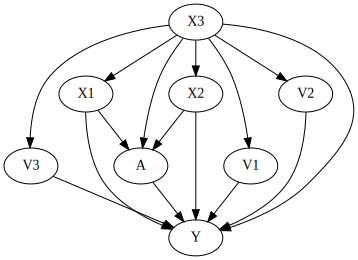

In [5]:
g = gr.Digraph()
g.edge("X3", "V3"),g.edge("X3", "X1"),g.edge("X3", "X2"),g.edge("X3", "V1"),g.edge("X3","V2"),g.edge("X1", "A"),g.edge("X2", "A"),g.edge("X3", "A"),g.edge("V1", "Y"),g.edge("V2", "Y"),g.edge("V3", "Y"),g.edge("X1", "Y"),g.edge("X2", "Y"),g.edge("X3", "Y"),g.edge("A", "Y")
g

Test PC algorithm

With default independence test

In [6]:
# default parameters
est_pc = pc(simul_pe_data.values)

  0%|          | 0/9 [00:00<?, ?it/s]

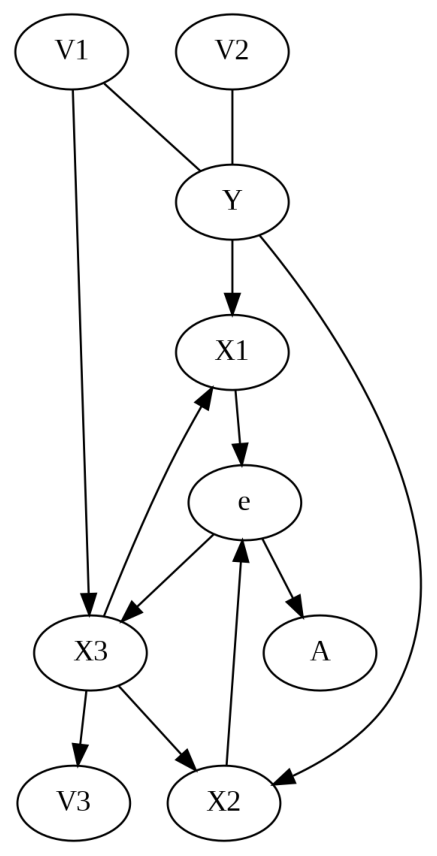

In [7]:
# visualization using pydot
est_pc.draw_pydot_graph(labels=["X1","X2","X3","A","V1","V2","V3","Y","e"])

pyd = GraphUtils.to_pydot(est_pc.G)
pyd.write_png('test_pc_algo.png')

Even the skeleton is not correct!

We try other another independence test

In [8]:
# default parameters
est_pc_kci = pc(simul_pe_data.values,indep_test="kci")

  0%|          | 0/9 [00:00<?, ?it/s]

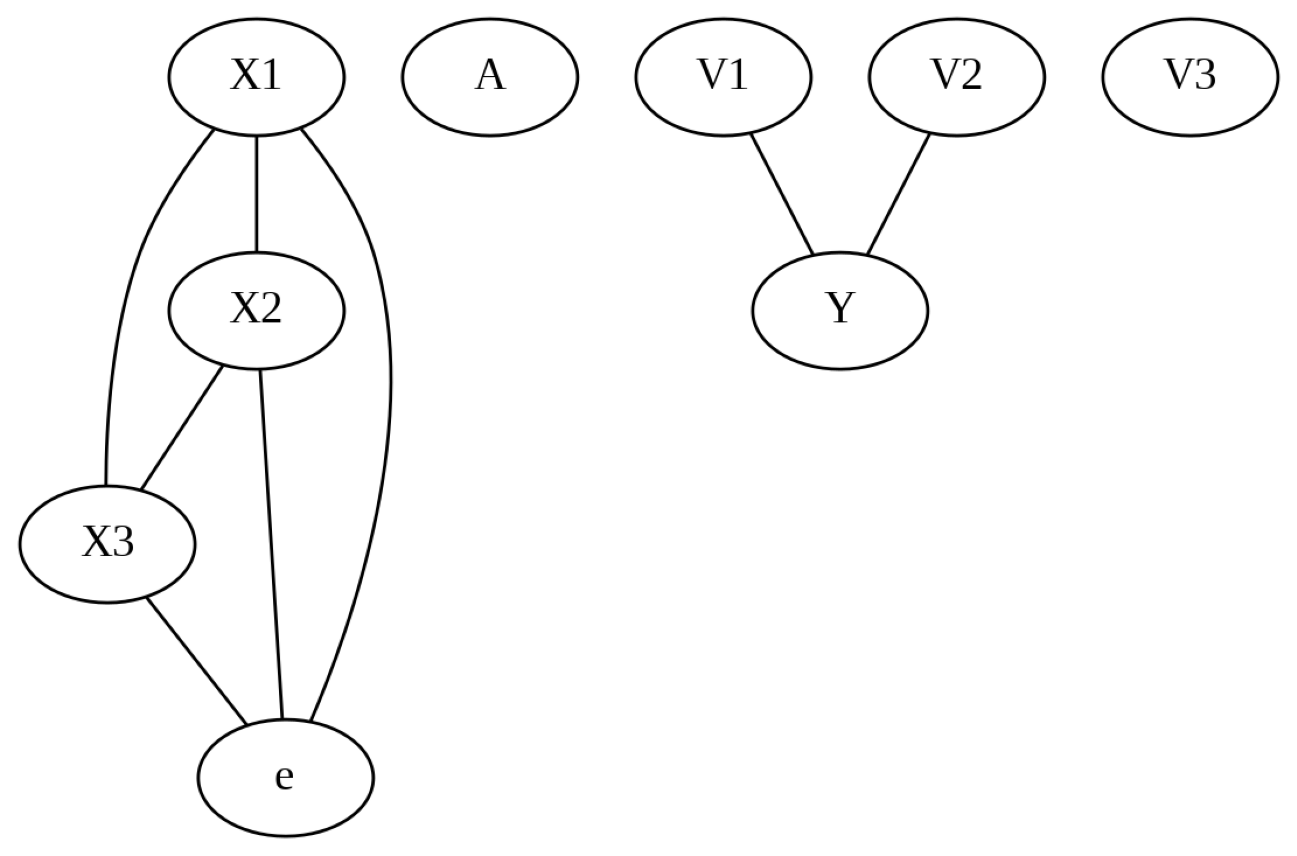

In [9]:
# visualization using pydot
est_pc_kci.draw_pydot_graph(labels=["X1","X2","X3","A","V1","V2","V3","Y","e"])

pyd = GraphUtils.to_pydot(est_pc.G)
pyd.write_png('test_pc_algo_kci.png')

Not better! In addition, the method does not scale...Try with 1000 observations or more

##Lingam

In [10]:
model = lingam.DirectLiNGAM()
model.fit(simul_pe_data.values)

In [11]:
model.adjacency_matrix_

array([[  0.        ,   0.        ,  -0.58511135,   0.        ,
          0.        ,   0.        ,   0.        ,  -0.06264041,
          3.97457766],
       [  0.66421678,   0.        ,   0.94095297,  -0.13498969,
          0.        ,   0.        ,   0.        ,   0.09083357,
         -6.70172817],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.5180729 ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [ -0.08041022,   0.        ,   0.25972549,   0.50250743,
          0.        ,   0.        ,   0.30235918,  -0.28586526,
         -0.97470855],
       [  0.        ,   0.        ,   0.        ,  -0.58485077,
          0.11061053,   0.        ,  -0.34161675,   0.3063308 ,
          0.72972436],
       [  0.        ,   0.        ,   0.47388105,   0.        ,
          0.        ,   0.    

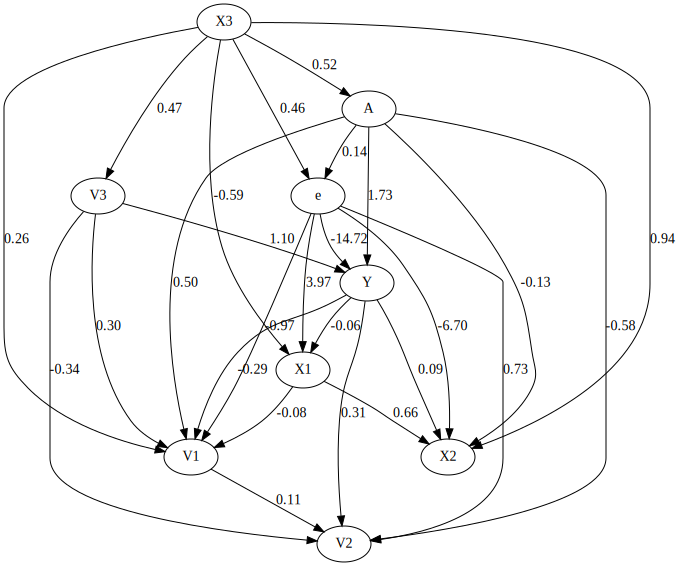

In [12]:
make_dot(model.adjacency_matrix_,labels=["X1","X2","X3","A","V1","V2","V3","Y","e"])

Much better, even if the model is non linear. The coefficients are not meaningful